In [1]:
# import required packages
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import pickle
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.set_floatx('float32')
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from matplotlib.pyplot import imshow
%matplotlib inline
import pandas as pd
from keras.callbacks import ModelCheckpoint

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
# obtain train/val/test sets
with open('x_train_movieposter.txt', 'rb') as file:
    X_train = np.array(pickle.load(file))
with open('x_val_movieposter.txt', 'rb') as file:
    X_val = np.array(pickle.load(file))
with open('x_test_movieposter.txt', 'rb') as file:
    X_test = np.array(pickle.load(file))
with open('y_test2_movieposter.txt', 'rb') as file:
    Y_test = np.array(pickle.load(file))
with open('y_val2_movieposter.txt', 'rb') as file:
    Y_val = np.array(pickle.load(file))
with open('y_train2_movieposter.txt', 'rb') as file:
    Y_train = np.array(pickle.load(file))

In [ ]:
# check the dimensions of each set
X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

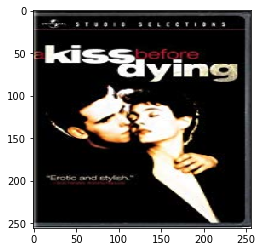

In [23]:
plt.imshow(X_train[0])

In [4]:
# preprocess the inputs
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [5]:
# recall deep learning model without the fully connected layer
resnet50 = ResNet50(input_shape = (256, 256, 3), include_top=False, weights=None, pooling='max')

In [6]:
# build fully connected layer with the last layer composed of 7 nodes/genres
model = models.Sequential()
model.add(resnet50)
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 25,817,991
Trainable params: 25,764,871
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
# check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.training.Model object at 0x7fdc2c4198d0> True
<keras.layers.core.Dense object at 0x7fdc2c438cc0> True
<keras.layers.core.Dense object at 0x7fdc2c438da0> True
<keras.layers.core.Dense object at 0x7fdc2bfb9630> True


In [7]:
# count the total number for each genres
ytrain_df = pd.DataFrame(Y_train2)
ytrain_df.sum(axis=0)

0    15152
1     9510
2     4733
3     3997
4     4004
5     3669
6     4573
dtype: int64

In [8]:
# compose class weights on imbalanced dataset
nclasses = 7
bincount = np.array([15152, 9510, 4733, 3997, 4004, 3669, 4573])
class_weights = {k: len(Y_train)/(nclasses*bincount[k]) for k in range(nclasses)}
genres = ['Drama', 'Comedy', 'Romance', 'Action', 'Crime', 'Thriller', 'Others']

In [9]:
# check class weights 
class_weights

{0: 0.28178269723940264,
 1: 0.44895598617996096,
 2: 0.9020856599559325,
 3: 1.0681940026448409,
 4: 1.066326530612245,
 5: 1.1636880426741425,
 6: 0.9336478085658055}

In [10]:
# compile model 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [11]:
# schedule the learning rate during the training of the model
def scheduler(epoch):
    if epoch <= 10:
        return 0.001
    else:
        return 0.001 * np.exp(0.1*(10 - epoch))

lr_scheduler = keras.callbacks.callbacks.LearningRateScheduler(scheduler)

In [12]:
# save the best model with weigths after each epoch
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [13]:
# train the model
hist = model.fit(X_train, Y_train2, batch_size=32, epochs=20, callbacks=[checkpoint, lr_scheduler], class_weight=class_weights, validation_data=(X_val, Y_val2))
model.summary()

Train on 29887 samples, validate on 3321 samples
Epoch 1/20
29887/29887 [==============================] - 1447s 48ms/step - loss: 0.2838 - accuracy: 0.7760 - val_loss: 0.5070 - val_accuracy: 0.7783

Epoch 00001: loss improved from inf to 0.28380, saving model to best_model.hdf5
Epoch 2/20
29887/29887 [==============================] - 1415s 47ms/step - loss: 0.2485 - accuracy: 0.7813 - val_loss: 0.4845 - val_accuracy: 0.7836

Epoch 00002: loss improved from 0.28380 to 0.24848, saving model to best_model.hdf5
Epoch 3/20
29887/29887 [==============================] - 1415s 47ms/step - loss: 0.2459 - accuracy: 0.7826 - val_loss: 0.4868 - val_accuracy: 0.7863

Epoch 00003: loss improved from 0.24848 to 0.24590, saving model to best_model.hdf5
Epoch 4/20
29887/29887 [==============================] - 1417s 47ms/step - loss: 0.2440 - accuracy: 0.7829 - val_loss: 0.4876 - val_accuracy: 0.7853

Epoch 00004: loss improved from 0.24590 to 0.24399, saving model to best_model.hdf5
Epoch 5/20
2988

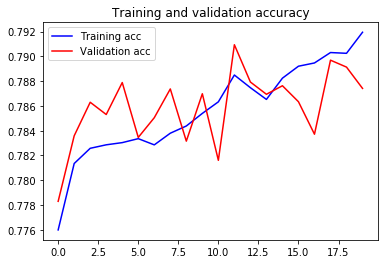

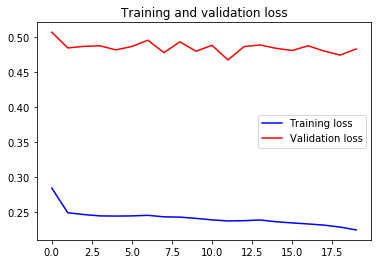

<Figure size 432x288 with 0 Axes>

In [14]:
# plot training & validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Training and validation loss')
plt.show()




In [40]:
# make prediction on test set
prediction = model.predict(X_test)

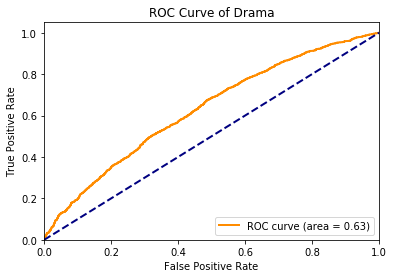

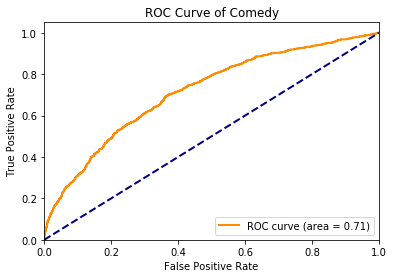

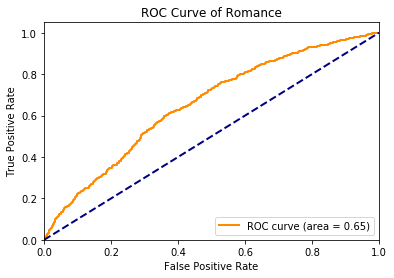

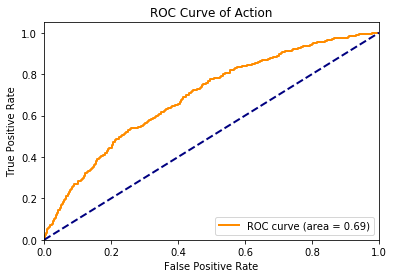

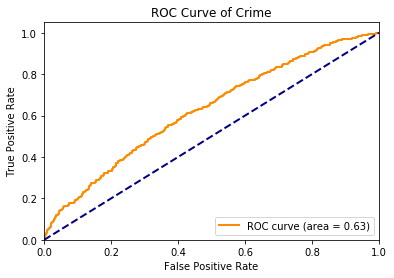

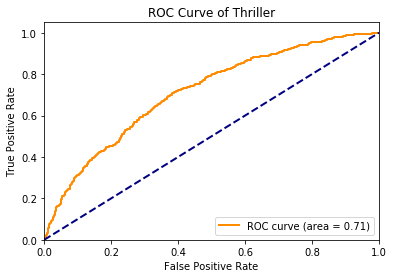

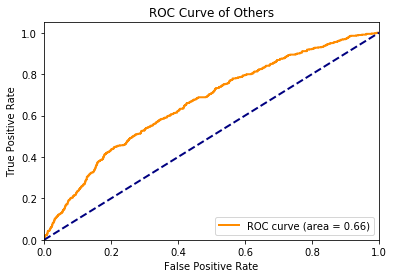

In [43]:
# plot ROC curve 

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = 7  #number of genres
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(Y_test2[:])[:,i], np.array(prediction[:])[:,i]) #use prediction probabilty 
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test2.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of ' + str(genres[i]))
    plt.legend(loc="lower right")
    plt.savefig('ROC Curve of ' + str(genres[i]))
    plt.show()
    

<Figure size 432x288 with 0 Axes>

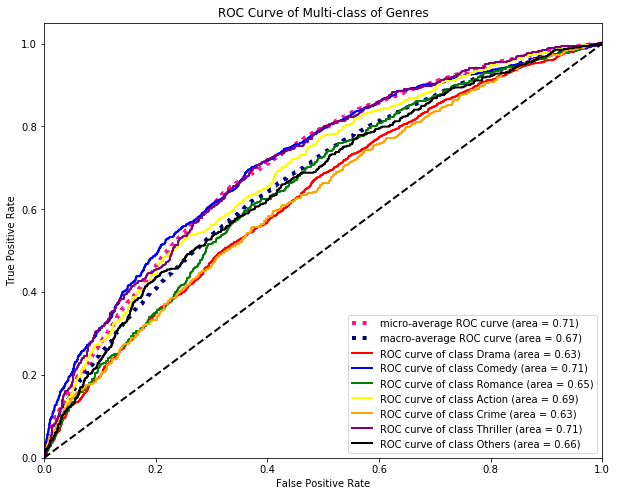

In [44]:
# plot ROC curves of each genre in one plot
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# plot all ROC curves
plt.figure()
plt.figure(figsize=[10, 8])
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'black']
for i, colors in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=colors, lw=2,
             label='ROC curve of class ' + str(genres[i])+ ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Multi-class of Genres')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_of_Multi-class_of_Genres')
plt.show()


In [29]:
# assign decision thresholds for each genre
pred = []
threshold = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
for i in range(n_classes):
    y = np.array(prediction)[:,i]
    y[y >= threshold[i]] = 1
    y[y < threshold[i]] = 0
    pred.append(y)
pred = np.array(pred).transpose()

In [30]:
# calculate f1, precision, recall score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
f1 = dict()
precision = dict()
recall = dict()
for i in range(n_classes):
    f1[i] = f1_score(np.array(Y_test2)[:,i], np.array(pred)[:,i], average='macro')
    f1[i] = f1_score(np.array(Y_test2)[:,i], np.array(pred)[:,i], average='micro')
    precision[i] = precision_score(np.array(Y_test2)[:,i], np.array(pred)[:,i])
    recall[i] = recall_score(np.array(Y_test2)[:,i], np.array(pred)[:,i])
    

In [39]:
# calculate perfect score = the number of correct genre(s) of a movie / total number of movies
counter = 0
for i in range(len(pred)):
    inner_counter = 0
    for j in range(7):
        if int(pred[i][j]) == Y_test2[i][j]:
            inner_counter += 1
    if inner_counter >= 7:
        counter += 1
                
perfectscore = counter / len(pred)
perfectscore

0.3840108401084011